In [27]:
import torch
from torch import nn
from torch import functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tqdm

Задание 1. Генератор батчей (batch generator)
В этот раз мы хотим сделать генератор, который будет максимально похож на то, что используется в реальном обучении.

С помощью numpy вам нужно перемешать исходную выборку и выбирать из нее батчи размером batch_size, если размер выборки не делился на размер батча, то последний батч должен иметь размер меньше batch_size и состоять просто из всех оставшихся объектов.

You also can test you code here: pik.org/lesson/278387/step/2

In [28]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    pos = np.random.permutation(len(X))
    for i in range(0, len(X), batch_size):
        X_batch = X[pos[i: i + batch_size]]
        y_batch = y[pos[i: i + batch_size]]
    yield (X_batch, y_batch)

In [29]:
df = pd.read_csv('iris.csv', sep = ',')

In [30]:
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [31]:
df['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [32]:
target_mapping = {
    'Setosa': 0,
    'Versicolor': 1,
    'Virginica': 2
}
feature_columns = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
target_column = 'variety'
X = np.array(df[feature_columns])
y = np.array(df[target_column])

# encode target with target_mapping
y = np.array([target_mapping[cls] for cls in y])

In [33]:
# Просто вычтите среднее и поделитe на стандартное отклонение. Также преобразуйте всё в np.array
X_mean = np.mean(X, axis = 0)
X_std = np.std(X, axis = 0)
X = np.array((X - X_mean)/X_std)

In [34]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры, чтобы потом было удобнее
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(len(X[0]), 10),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.BatchNorm1d(10),
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.BatchNorm1d(20),
    nn.Linear(20, 3),
)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [268]:
torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(len(X[0]), 10),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.BatchNorm1d(10),
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.BatchNorm1d(20),
    nn.Linear(20, 3)
)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [269]:
    num_epoch = 85
    train_losses = []
    for i in tqdm.tqdm(range(num_epoch)):
        epoch_train_losses = []
        for X_batch, y_batch in batch_generator(X_train, y_train, 30):
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # зануляем градиент
            optimizer.zero_grad()
            # backward
            loss.backward()
            # ОБНОВЛЯЕМ веса
            optimizer.step()
            # Запишем число (не тензор) в наши батчевые лоссы
            epoch_train_losses.append(loss.detach().numpy())     
        #train_losses в traom_losses записываем среднюю epoch_train_losses
        train_losses.append(np.mean(epoch_train_losses))    

100%|██████████| 85/85 [00:00<00:00, 444.42it/s]


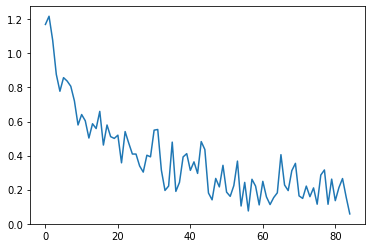

In [270]:
#визуализируем график ошибки 
plt.plot(range(len(train_losses)), train_losses, label='train')

In [271]:
#посчитаем y_pred по тестовым данных (используйте model.forward)
y_pred = model.forward(X_test)

In [272]:
print(y_pred)

tensor([[-2.4244e+00,  3.3590e+00,  4.8767e-03],
        [ 4.9537e+00, -1.9391e+00, -3.9183e+00],
        [-6.3235e+00, -7.6417e-01,  3.3294e+00],
        [-2.7481e+00,  3.2901e+00, -1.2471e-01],
        [-2.4346e+00,  2.8858e+00,  7.1068e-01],
        [ 5.1919e+00, -2.4637e+00, -3.8479e+00],
        [-2.1247e+00,  3.6380e+00, -1.3655e+00],
        [-6.0657e+00, -2.3637e+00,  4.4748e+00],
        [-4.7109e+00,  2.1699e+00,  1.0533e+00],
        [-1.9992e+00,  3.5042e+00, -1.2535e+00],
        [-4.2389e+00,  6.3086e-01,  2.9111e+00],
        [ 3.3243e+00, -2.3273e+00, -1.7833e+00],
        [ 5.7059e-01,  2.0455e+00, -9.7352e-01],
        [ 3.7102e+00, -1.1236e+00, -3.1044e+00],
        [ 1.7034e+00, -1.0747e-01, -2.2934e+00],
        [-2.4963e+00,  3.0233e+00,  1.9283e-01],
        [-4.6661e+00,  2.4002e+00,  3.6300e+00],
        [-2.4575e+00,  3.5461e+00, -6.1024e-01],
        [-1.7514e+00,  3.5881e+00, -4.5667e-01],
        [-8.6930e+00, -1.1608e+00,  3.1019e+00],
        [ 3.3946e+00

In [273]:
#как мы видим y pred возвращает вектора, длиной в три, нам необходимо найти максимальный индекс элемента - 
#это и будет предполагаемый класс
y_pred=y_pred.detach().numpy()

In [274]:
y_pred = np.argmax(y_pred, axis=-1)

In [275]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[14  1  0]
 [ 0 11  0]
 [ 0  2 10]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.79      1.00      0.88        11
           2       1.00      0.83      0.91        12

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38



In [201]:
#точность с заданными параметрами будет около 95% но IRIS очен легкий датасет, на котором и обычные статистические 
#модели ипа KNN SVM показывают 100% точность, поменяйте количество нейронов, lr epoch так, чтобы этого добиться